## Problem 4

In [1]:
import torch
from torch import Tensor, tensor
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import Dataset, TensorDataset, DataLoader
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
batch_size = 64
learning_rate = 5e-4
num_epochs = 2000
reg_coeff = 500
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [3]:
def make_swiss_roll(n_samples=2000, noise = 1.0, dimension = 2, a = 20, b = 5):
    """
    Generate 2D swiss roll dataset 
    """
    t = 2 * np.pi * np.sqrt(np.random.uniform(0.25,4,n_samples))
    
    X = 0.1 * t * np.cos(t)
    Y = 0.1 * t * np.sin(t)
    
    errors = 0.025 * np.random.multivariate_normal(np.zeros(2), np.eye(dimension), size = n_samples)
    X += errors[:, 0]
    Y += errors[:, 1]
    return np.stack((X, Y)).T

def show_data(data, title):
    """
    Plot the data distribution
    """
    sns.set(rc={'axes.facecolor': 'honeydew', 'figure.figsize': (5.0, 5.0)})
    plt.figure(figsize = (5, 5))
    plt.rc('text', usetex = False)
    plt.rc('font', family = 'serif')
    plt.rc('font', size = 10)
    
    g = sns.kdeplot(x=data[:, 0], y=data[:, 1], fill=True, thresh=0.1, levels=1000, cmap="Greens")
    
    g.grid(False)
    plt.margins(0, 0)
    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.title(title)
    plt.show()

In [4]:
class SwissRollDataset(Dataset) : 
    def __init__(self, data) : 
        super().__init__()
        self.data = torch.from_numpy(data)
        self.data = self.data.to(dtype=torch.float)
    
    def __len__(self) : 
        return len(self.data)
    
    def __getitem__(self, idx) :
        return self.data[idx]


data = make_swiss_roll()
dataset = SwissRollDataset(data)
loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)

Similar to problem 3, define generator, discriminator, and variables.

In [9]:
z_dim = 100

class Generator(nn.Module):
    def __init__(self, input_dim = z_dim, output_dim = 2):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_dim, 32),
                                     nn.Tanh(),
                                     nn.Linear(32,output_dim))
    
    def forward(self, x):
        return self.network(x)


class Discriminator(nn.Module):
    def __init__(self, input_dim = 2):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(input_dim, 128),
                                     nn.Tanh(),
                                     nn.Linear(128,128),
                                     nn.Tanh(),
                                     nn.Linear(128,1),
                                     nn.Sigmoid())
        
    def forward(self,x):
        return self.network(x)

gen = Generator().to(device)
dis = Discriminator().to(device)

gen_optimizer = optim.Adam(gen.parameters(), lr=learning_rate)
dis_optimizer = optim.Adam(dis.parameters(), lr=learning_rate)

Next we train models.

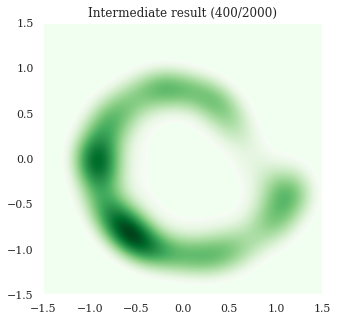

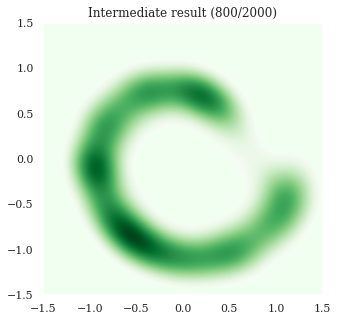

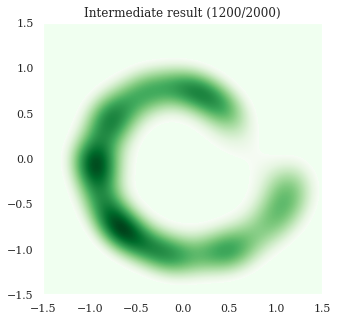

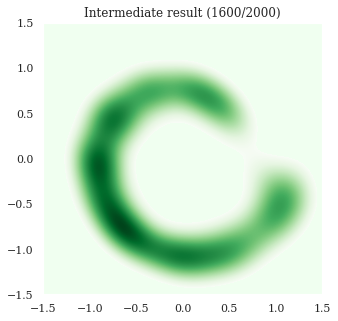

In [10]:
for epoch in range(1,num_epochs):
    for batch_idx, x in enumerate(loader):
        x = x.detach().to(device)
        D_real_loss = torch.mean(torch.log(dis(x)))
        z = torch.randn(batch_size, z_dim).to(device)
        D_fake_loss = torch.mean(torch.log(1-dis(gen(z))))
        D_loss = - D_real_loss - D_fake_loss
        
        dis.zero_grad()
        D_loss.backward()
        dis_optimizer.step()
        
        z = torch.randn(batch_size, z_dim).to(device)
        G_loss = -torch.mean(torch.log(dis(gen(z))))
        
        gen.zero_grad()
        G_loss.backward()
        gen_optimizer.step()
    
    if epoch % (num_epochs // 5) == 0:
        z = torch.randn(2000, z_dim).to(device)
        image = gen(z).detach().cpu().numpy()
        show_data(image, f"Intermediate result ({epoch}/{num_epochs})")

Unlike we expected, not entire roll shape is constructed. This may becomes input dimension of generator z_dim is not enoughly large.  
Below is final result.

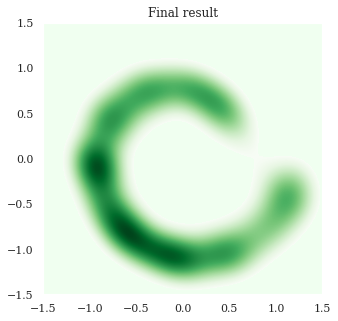

In [11]:
z = torch.randn(2000, z_dim).to(device)
image = gen(z).detach().cpu().numpy()
show_data(image, f"Final result")